https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import os

import matplotlib.pyplot as plt

In [60]:
# Import the data from CSV
this_dir = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(this_dir, 'house_data')
train = pd.read_csv(data_path + '\\train.csv')
test = pd.read_csv(data_path + '\\test.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(array([ 22., 126., 380., 343., 229., 144.,  86.,  49.,  28.,  23.,  12.,
          7.,   3.,   1.,   2.,   1.,   2.,   0.,   0.,   2.]),
 array([ 34900.,  70905., 106910., 142915., 178920., 214925., 250930.,
        286935., 322940., 358945., 394950., 430955., 466960., 502965.,
        538970., 574975., 610980., 646985., 682990., 718995., 755000.]),
 <BarContainer object of 20 artists>)

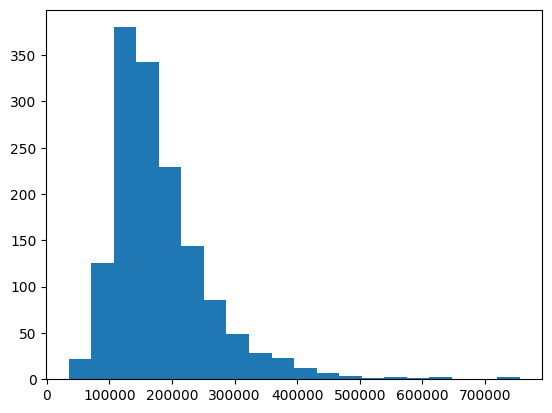

In [ ]:
plt.hist(train['SalePrice'], bins=20)
plt.title('SalePrice histogram, unadjusted')

In [56]:
# Preprocess the data

# Take the log of saleprice to reduce right skew of housing prices
train['SalePrice'] = np.log1p(train['SalePrice'])

def clean_columns(df):
    # Fill missing numerical values
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(0)

    # Fill missing object values
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna("None")

    # Convert categoricals to 'category' dtype for native handling
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
    return df

train = clean_columns(train)

X = train.drop('SalePrice', axis=1)
y = train[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [57]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10, 15, 20],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1],
}

model = XGBRegressor(
    random_state=0,
    enable_categorical=True,
    objective='reg:squarederror',
    tree_method='hist'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=4
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(mse)
# Get the original non-log price
y_test['Y'] = np.expm1(y_test['SalePrice'])
# Get the predicted non-log price
y_test['Pred'] = np.expm1(preds)
y_test.head(50)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'colsample_bytree': 0.7, 'gamma': 0, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}
0.019779212772846222


,SalePrice,Y,Pred
529,12.209193,200624.0,265972.968750
491,11.798112,133000.0,147684.546875
459,11.608245,110000.0,99707.851562
279,12.165256,192000.0,214761.171875
655,11.385103,88000.0,89722.976562
1013,11.350418,85000.0,107724.156250
1403,12.552930,282922.0,257380.312500
601,11.856522,141000.0,125193.546875
1182,13.521141,745000.0,615515.125000
687,11.910365,148800.0,158231.359375
